<a href="https://colab.research.google.com/github/AnSaradar/Diabetic-Retinopathy-Detection/blob/main/Diabetic_Retinopathy_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset

In [1]:
!git clone https://github.com/kumailht/diabetic-retinopathy

Cloning into 'diabetic-retinopathy'...
remote: Enumerating objects: 5626, done.
remote: Total 5626 (delta 0), reused 0 (delta 0), pack-reused 5626
Receiving objects: 100% (5626/5626), 757.22 MiB | 25.37 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (2784/2784), done.


# Importing Libraries

In [5]:
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.applications import VGG16

import cv2

import os
import numpy as np
import itertools
import random

from collections import Counter

from glob import iglob

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt




# Setting The Constant Hyperparameters

In [16]:
# Set dataset storage folder path
BASE_DATASET_FOLDER = "/content/diabetic-retinopathy/data"
TRAIN_FOLDER = "training"
VALIDATION_FOLDER = "validation"
TEST_FOLDER = "test"

# ResNet50 image size
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

# Keras settings
TRAIN_BATCH_SIZE = 80
VAL_BATCH_SIZE = 15
batch_size = 32
EPOCHS = 50
LEARNING_RATE = 0.0001

MODEL_PATH = os.path.join("Diabetic_Retinopathy_Detector.h5")
MODEL_WEIGHTS_PATH = os.path.join("Diabetic_Retinopathy_Model_Weights.h5")


# Setting up the GPU

In [7]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)


# Image Handling with Data Augmentation

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER),
    target_size=IMAGE_SIZE,
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)


val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER),
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER),
    target_size=IMAGE_SIZE,
    batch_size=VAL_BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)




Found 1659 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 560 images belonging to 5 classes.


# Model Building & Training

## Importing VGG Model (Transfer Learning)

In [9]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


## Building The CNN Architicture

In [10]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 6

## Model Compiling

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

## Model Fitting

In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size)

<ipython-input-13-b954039d9a5d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
20/20 [==============================] - 58s 2s/step - loss: 2.0613 - acc: 0.2438 - val_loss: 1.6357 - val_acc: 0.2574
Epoch 2/50
20/20 [==============================] - 28s 1s/step - loss: 1.6260 - acc: 0.2489 - val_loss: 1.5533 - val_acc: 0.2555
Epoch 3/50
20/20 [==============================] - 28s 1s/step - loss: 1.5748 - acc: 0.2362 - val_loss: 1.5607 - val_acc: 0.2555
Epoch 4/50
20/20 [==============================] - 28s 1s/step - loss: 1.5600 - acc: 0.2533 - val_loss: 1.5459 - val_acc: 0.2555
Epoch 5/50
20/20 [==============================] - 30s 2s/step - loss: 1.5530 - acc: 0.2514 - val_loss: 1.5419 - val_acc: 0.2555
Epoch 6/50
20/20 [==============================] - 28s 1s/step - loss: 1.5509 - acc: 0.2470 - val_loss: 1.5410 - val_acc: 0.2555
Epoch 7/50
20/20 [==============================] - 28s 1s/step - loss: 1.5512 - acc: 0.2508 - val_loss: 1.5415 - val_acc: 0.2555
Epoch 8/50
20/20 [==============================] - 29s 1s/step - loss: 1.5499 - acc: 0.26

## Save The Model & The Weights

In [ ]:
model.save(MODEL_PATH)


# Testing The Model

In [17]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
print("Test Accuracy:", test_accuracy)

17/17 [==============================] - 1s 75ms/step - loss: 1.3737 - acc: 0.5529
Test Accuracy: 0.5529412031173706


# Training & Validation Curve

In [31]:
def plot_training_history(history):
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

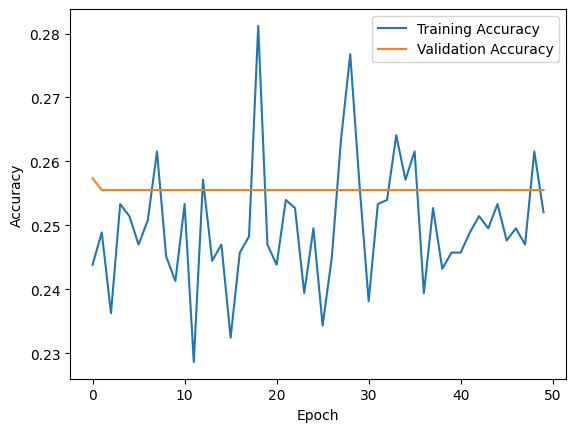

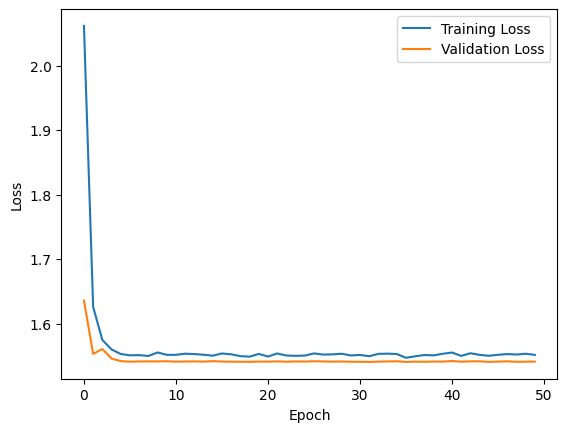

In [32]:
plot_training_history(history)

# Try your own image

In [18]:
import requests
from PIL import Image
from io import BytesIO

def classify_image(image_url, model):

    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    img = img.resize((150, 150))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    class_probabilities = model.predict(img_array)
    predicted_class = np.argmax(class_probabilities)

    return predicted_class

In [ ]:
image_url = "URL_OF_YOUR_IMAGE"
predicted_class = classify_image(image_url, model)
print("Predicted Class:", predicted_class)